<a href="https://colab.research.google.com/github/stavco9/rs-final-project/blob/main/recsys2022/Models_for_ensemble/7a-TwoTower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
just_checking_integrity=False
rows=3000
test_rows=1000

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.metrics import MeanMetricWrapper
import numpy as np
import datetime
from itertools import compress
from math import sin, cos
import ast
import os
import gc
import pickle
import keras.models

In [3]:
from tqdm.auto import tqdm
tqdm.pandas()

## Custom metric

In [4]:
def mrr_top_at(at=100):
    @tf.function
    def mrr_top(y_true,y_pred):
        top_k=tf.math.top_k(y_pred,k=at)
        rr=top_k.indices
        #print(rr)
        idx=tf.range(start=1,limit=at+1,delta=1)
        y_true=tf.reshape(y_true,[-1,1])
        #print(y_true)
        #y_true=tf.broadcast_to(y_true,test.shape)
        y_true=tf.cast(y_true,tf.int32)
        ranking=tf.where(tf.math.equal(rr,y_true),idx,0)
        #print(ranking)
        ranking=tf.reduce_sum(ranking,axis=-1)
        ranking=tf.where(ranking>0,1/ranking,0)
        #print(ranking)
        ranking=tf.reduce_mean(ranking)
        return ranking
    return mrr_top

@keras.saving.register_keras_serializable(package="CustomMetrics")
class MRRTopAt(MeanMetricWrapper):
    def __init__(self, at=100, **kwargs):
        super(MRRTopAt, self).__init__(mrr_top_at(at=100), **kwargs)

## Custom layers

In [5]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        embed_dim = config.pop("embed_dim")
        num_heads = config.pop("num_heads")
        ff_dim = config.pop("ff_dim")
        rate = config.pop("rate")
        return cls(embed_dim, num_heads, ff_dim, rate, **config)

In [6]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        vocab_size,
        embed_dim,
        item_embedding_trainable=True,
        embedding_weights=None,
        **kwargs
        ):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            trainable=item_embedding_trainable,
            weights=embedding_weights
            )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.item_embedding_trainable = item_embedding_trainable
        self.embedding_weights = embedding_weights

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=maxlen-1, limit=0, delta=-1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        base_config = super().get_config()
        config = {
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "item_embedding_trainable": self.item_embedding_trainable,
            "embedding_weights": self.embedding_weights
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        token_emb_config = config.pop("token_emb")
        pos_emb_config = config.pop("pos_emb")
        maxlen = config.pop("maxlen")
        vocab_size = config.pop("vocab_size")
        embed_dim = config.pop("embed_dim")
        item_embedding_trainable = config.pop("item_embedding_trainable")
        embedding_weights = config.pop("embedding_weights")
        return cls(maxlen, vocab_size, embed_dim, item_embedding_trainable, embedding_weights, **config)

In [7]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class PositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        embed_dim,
        **kwargs
        ):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return positions

    def get_config(self):
      base_config = super().get_config()
      config = {
          "maxlen": self.maxlen,
          "embed_dim": self.embed_dim
      }
      return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        maxlen = config.pop("maxlen")
        embed_dim = config.pop("embed_dim")
        return cls(maxlen, embed_dim, **config)

# Prepare dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project


In [9]:
candidate_items = pd.read_csv('./dataset/processed_data/candidate_items_mapped.csv')
candidate_items.head()

,item_id
0,1
1,2
2,3
3,4
4,5


In [10]:
embedding_weights = np.load('./dataset/processed_data/compressed_features.npy')
import os
import scipy.sparse as sps
def get_ICM(files_directory="./dataset/processed_data"):
    df_icm = pd.read_csv(filepath_or_buffer=os.path.join(files_directory, 'simplified_features_and_categories_30.csv'), sep=',', header=0)

    item_id_list = df_icm['item_id'].values
    feat_id_list = df_icm['feature_idx'].values
    rating_id_list = np.ones_like(feat_id_list)
    ICM_matrix = sps.csr_matrix((rating_id_list, (item_id_list, feat_id_list)))
    return ICM_matrix

ICM=get_ICM()
embedding_weights.shape

(23692, 64)

In [11]:
result =  pd.read_csv("./dataset/processed_data/macro_feats_NN.csv",parse_dates=["date_session_starting"],
     infer_datetime_format=True)



result["item_id"]=result["item_id"].map(ast.literal_eval)
result["timedelta"]=result["timedelta"].map(ast.literal_eval)

def is_reseen(x):
    #print(x)
    seen={}
    res=[]
    for item in x:
        if item in seen:
            res.append(seen[item])
            seen[item]+=1
        else:
            res.append(0)
            seen[item]=1
    return res

def percentage_seen(x):
    size=len(x)
    return [(i+1)/size for i in range(size)]

In [12]:
x_reseen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(is_reseen),
    padding='post',
    maxlen=100,
    dtype="int16"
)
x_percentage_seen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(percentage_seen),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [13]:
def similarity_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=embedding_weights[x]
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod



def similarity_feats_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=ICM[x].toarray()
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod

In [14]:
x_simils = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)
x_simils_feats = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_feats_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [15]:
static_features_names = [
                   'date_hour_sin',
                   'date_hour_cos',
                   'date_day_sin',
                   'date_day_cos',
                   'date_month_sin',
                   'date_month_cos',
                   'date_hour_sin_ending',
                   'date_hour_cos_ending',
                   'date_day_sin_ending',
                   'date_day_cos_ending',
                   'date_month_sin_ending',
                   'date_month_cos_ending',
                   'date_year_2020',
                   'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',
                   'user_went_afk',
                   'is_weekend',
                   'is_hot_hour',
                   'is_night',
                   'is_christmas_time',
                   'is_black_friday',
                   'session_similarity',
                   'session_similarity_uniques',
                   'session_similarity_feats',
                   'session_similarity_feats_uniques'
]
for col in ['length_of_session_seconds','avg_time_spent_per_item_seconds','variance_time_spent_per_item_seconds']:
    result[col]=np.log10(result[col]+1)
for col in ['n_seen_items','n_unique_items']:
    result[col]=result[col]/100

item_related_features = ['timedelta']

In [16]:
if just_checking_integrity:
    train_purchases = pd.read_csv(
    './dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    nrows=len(result)
    )
else:
    train_purchases = pd.read_csv(
    './dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    )
train_purchases.head()

,session_id,item_id
0,663204,12492
1,85375,3299
2,374472,17411
3,526578,11229
4,66630,11568


In [17]:
train_purchases.sort_values(by="session_id",inplace=True)

In [18]:
x_ids = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'],
    padding='post',
    maxlen=100,
)

In [19]:
for item_related_feature in item_related_features:
  print('Padding {}'.format(item_related_feature))
  x_item_related = tf.keras.preprocessing.sequence.pad_sequences(
      result[item_related_feature],
      dtype='float16',
      maxlen=100,
      padding='post'
    )

Padding timedelta


In [20]:
if len(item_related_features) == 1:
  x_item_related = np.expand_dims(x_item_related, axis=-1)

In [21]:
y = train_purchases['item_id'].to_numpy()

In [22]:
y_features = embedding_weights[y]

In [23]:
last_month_start = datetime.datetime.strptime("01/05/21 00:00:00", '%d/%m/%y %H:%M:%S')
static_features=result[static_features_names].to_numpy()

indexer = result["date_session_starting"]>=last_month_start

x_session_ids_last_month=result["session_id"][indexer]
x_ids_last_month=x_ids[indexer,:]
x_reseen_last_month=x_reseen[indexer,:]
x_simils_last_month=x_simils[indexer,:]
x_simils_feats_last_month=x_simils_feats[indexer,:]
x_percentage_seen_last_month=x_percentage_seen[indexer,:]
static_features_last_month=static_features[indexer,:]
x_item_related_last_month=x_item_related[indexer,:]
y_last_month=y[indexer]
y_features_last_month=y_features[indexer,:]

indexer_train = result["date_session_starting"]<last_month_start

x_ids=x_ids[indexer_train,:]
x_reseen=x_reseen[indexer_train,:]
x_simils=x_simils[indexer_train,:]
x_simils_feats=x_simils_feats[indexer_train,:]
x_percentage_seen=x_percentage_seen[indexer_train,:]
static_features=static_features[indexer_train,:]
x_item_related=x_item_related[indexer_train,:]
y=y[indexer_train]
y_features=y_features[indexer_train,:]

In [24]:
x_ids_train, x_ids_test,\
x_reseen_train, x_reseen_test,\
x_simils_train,x_simils_test,\
x_simils_feats_train,x_simils_feats_test,\
x_percentage_seen_train,x_percentage_seen_test,\
x_static_train, x_static_test, \
x_item_related_train, x_item_related_test, \
y_train, y_test, \
y_features_train, y_features_test = train_test_split(
    x_ids,
    x_reseen,
    x_simils,
    x_simils_feats,
    x_percentage_seen,
    static_features,
    x_item_related,
    y,
    y_features,
    test_size=0.2,
    random_state=1234
    )

In [25]:
shape=y_features_train.shape[1]
print(shape)

64


In [26]:
del x_ids,x_reseen,x_simils,x_simils_feats,x_percentage_seen,result,x_item_related,y,y_features
import gc
gc.collect()

36

In [27]:
if not os.path.exists("./dataset/processed_data/two_towers_tmp"):
  os.makedirs("./dataset/processed_data/two_towers_tmp")

numpy_outputs = ['x_ids_train', 'x_reseen_train', 'x_percentage_seen_train', 'x_simils_train', \
                 'x_simils_feats_train', 'x_item_related_train', 'x_static_train', 'y_train', 'y_features_train', \
                 'x_ids_test', 'x_reseen_test', 'x_percentage_seen_test', 'x_simils_test', 'x_simils_feats_test', \
                 'x_item_related_test', 'x_static_test', 'y_test', 'y_features_test']
for np_output in numpy_outputs:
  np.save(f"./dataset/processed_data/two_towers_tmp/{np_output}.npy", globals()[np_output])

# Build Dataset

In [12]:
numpy_inputs = ['x_ids_train', 'x_reseen_train', 'x_percentage_seen_train', 'x_simils_train', \
                 'x_simils_feats_train', 'x_item_related_train', 'x_static_train', 'y_train', 'y_features_train', \
                 'x_ids_test', 'x_reseen_test', 'x_percentage_seen_test', 'x_simils_test', 'x_simils_feats_test', \
                 'x_item_related_test', 'x_static_test', 'y_test', 'y_features_test']
for np_input in numpy_inputs:
  print(f"Loading {np_input}")
  globals()[np_input] = np.load(f"./dataset/processed_data/two_towers_tmp/{np_input}.npy")

Loading x_ids_train
Loading x_reseen_train
Loading x_percentage_seen_train
Loading x_simils_train
Loading x_simils_feats_train
Loading x_item_related_train
Loading x_static_train
Loading y_train
Loading y_features_train
Loading x_ids_test
Loading x_reseen_test
Loading x_percentage_seen_test
Loading x_simils_test
Loading x_simils_feats_test
Loading x_item_related_test
Loading x_static_test
Loading y_test
Loading y_features_test


In [27]:
if just_checking_integrity:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(64,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(4, reshuffle_each_iteration=True)
else:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(512,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(1435, reshuffle_each_iteration=True)
test_set_complete = tf.data.Dataset.from_tensor_slices(
    ((x_ids_test, x_reseen_test/100, x_percentage_seen_test,x_simils_test,x_simils_feats_test, x_item_related_test, x_static_test), (y_test, y_features_test))
    ).batch(128)
gc.collect()

18

In [28]:
train_set_complete.element_spec

((TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)))

# Contex aware Transformer NET

In [29]:
static_features_names = [
                   'date_hour_sin',
                   'date_hour_cos',
                   'date_day_sin',
                   'date_day_cos',
                   'date_month_sin',
                   'date_month_cos',
                   'date_hour_sin_ending',
                   'date_hour_cos_ending',
                   'date_day_sin_ending',
                   'date_day_cos_ending',
                   'date_month_sin_ending',
                   'date_month_cos_ending',
                   'date_year_2020',
                   'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',
                   'user_went_afk',
                   'is_weekend',
                   'is_hot_hour',
                   'is_night',
                   'is_christmas_time',
                   'is_black_friday',
                   'session_similarity',
                   'session_similarity_uniques',
                   'session_similarity_feats',
                   'session_similarity_feats_uniques'
]

In [30]:
item_related_features = ['timedelta']
embed_dim = 64  # Embedding size for each token
maxlen = 100
num_static = len(static_features_names)
num_item_related = len(item_related_features)
vocabulary_size = 23692 #max(train_purchases['item_id']) # Size of the vocabulary
num_heads = 3
ff_dim = 128
transformer_width = 128 - num_static - num_item_related - 4
mlp_width = 256
mlp_depth = 2

last_layer_size = 19021


#######################################################################
########################### TWO TOWERS TRANSFORMER ####################
#######################################################################

class TwoTowerModel:

    def __init__(self, name, heads, mlp_depth, sessions_tower_height, items_tower_height,
                 id_inputs, x_reseen_inputs, x_percentage_seen_inputs,
                 x_simils_inputs, x_simils_feats_inputs, item_related_inputs, static_inputs):

        ############ input
        inputs = [id_inputs, x_reseen_inputs, x_percentage_seen_inputs,x_simils_inputs,x_simils_feats_inputs,item_related_inputs, static_inputs]

        ############ item model

        # (1) id_inputs for embedding
        learned_embedding = layers.Embedding(
            input_dim=vocabulary_size, output_dim=embed_dim, mask_zero=True, name='learned_embedding')(id_inputs)

        feature_embedding = layers.Embedding(
            input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], mask_zero=True,
            trainable=False, weights=[embedding_weights], name='feature_embedding')(id_inputs)

        # transformer
        embedding = layers.Concatenate(name='embedding')([learned_embedding, feature_embedding])
        embed_dim_transformer = embed_dim * 2
        positional_embedding = PositionEmbedding(maxlen, embed_dim=embed_dim_transformer)(id_inputs)
        x_pre = embedding + positional_embedding
        x_item = self.build_trasformer_tower(x_pre, embed_dim_transformer, items_tower_height)

        # mlp
        item_model = self.build_mlp_tower(x_item, tower_name='item_tower')

        ############ user session model

        # (2) item_related_inputs, x_reseen_inputs, x_percentage_seen_inputs, x_simils_inputs, x_simils_feats_inputs
        masked_item_related_inputs = item_related_inputs[:, :tf.shape(id_inputs)[-1], :]
        embedding = layers.Concatenate()(
            [masked_item_related_inputs, x_reseen_inputs, x_percentage_seen_inputs, x_simils_inputs,
             x_simils_feats_inputs])

        # transformer
        embed_dim_transformer = num_item_related + 4
        positional_embedding = PositionEmbedding(maxlen, embed_dim=embed_dim_transformer)(id_inputs)
        x_pre = embedding + positional_embedding
        x_session_sequence = self.build_trasformer_tower(x_pre, embed_dim_transformer, sessions_tower_height)

        # attention
        #x_session_sequence, attention = self.build_attention(x_session_sequence)

        # (3) static_inputs
        x_session = layers.Concatenate()([static_inputs, x_session_sequence])

        # mlp
        session_model = self.build_mlp_tower(x_session, tower_name='session_tower')

        ############ output - similarity
        similarity = layers.Multiply()([item_model, session_model])
        outputs = layers.Dense(last_layer_size, activation='softmax', name='y')(similarity)
        #secondary_outputs = layers.Dense(units=y_features_train.shape[1], activation='tanh', name='y_features')(x_pre)

        #super().__init__(inputs=inputs, outputs=outputs, name=name)
        self.core_model = keras.models.Model(inputs=inputs, outputs=outputs, name=name)


    def build_trasformer_tower(self, x, embed_dim_transformer, transformer_depth):
        for layer in range(transformer_depth):
            x_post = TransformerBlock(embed_dim_transformer, heads, ff_dim)(x)
            x = layers.Concatenate()([x_post, x])
            embed_dim_transformer *= 2

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(units=mlp_width-num_static, activation='linear')(x)

        return x

    def build_mlp_tower(self, x, tower_name):

        # towers levels (depth)
        for layer in range(mlp_depth):
            x_post = layers.LayerNormalization()(x)
            x_post = layers.Dropout(0.2)(x_post)
            x = layers.Dense(units=mlp_width, activation='gelu')(x_post)
            #x = layers.Add()([x, x_post])

        # tower last level before similarity
        last_layer = layers.Dense(last_layer_size, activation='relu', name=tower_name + '_last_layer')(x)

        return last_layer

In [31]:
# input

id_inputs = layers.Input(shape=(maxlen,), name='ids')
item_related_inputs = layers.Input(shape=(maxlen, num_item_related), name='item_related_features')
x_reseen_inputs = layers.Input(shape=(maxlen, 1), name='x_reseen_featurs')
x_percentage_seen_inputs = layers.Input(shape=(maxlen, 1), name='x_percentage_seen')
x_simils_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_embeddings')
x_simils_feats_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_ICM')
static_inputs = layers.Input(shape=(num_static,), name='static_features')

# Experimentation

In [32]:
PATH = './models/'

# training
gc.collect()
if just_checking_integrity:
    n_epochs=2
else:
    n_epochs=100

def check_existing_model(name):
    try:
        print(f"Trying to load model {name}")
        directory = os.fsencode(PATH)
        model = tf.keras.models.load_model(
            f'{PATH}/{name}.keras',
            safe_mode=False,
            custom_objects={
                "mrr_top": MRRTopAt(at=100),
                "TransformerBlock": TransformerBlock,
                "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
                "PositionEmbedding": PositionEmbedding
            })
        print(f"Model {name} loaded")
        return model
    except (OSError, IOError) as e:
        print("Model not found")
        return None

def save_history(model_obj, model_name):
    all_epochs = model_obj.history.history
    last_epoch = {measure_name: measure[-1] for measure_name, measure in all_epochs.items()}
    with open(os.path.join(PATH, f'{model_name}_results.pkl'), 'wb') as outp:
      pickle.dump(last_epoch, outp, pickle.HIGHEST_PROTOCOL)

def train(name, heads, mlp_layers, sessions_tower_height, items_tower_height):

    model = check_existing_model(name)
    start_time = datetime.datetime.now()
    if model is None:
        model = TwoTowerModel(
            name, heads, mlp_layers, sessions_tower_height, items_tower_height,
            id_inputs, x_reseen_inputs, x_percentage_seen_inputs,
            x_simils_inputs,x_simils_feats_inputs,item_related_inputs, static_inputs
        )
        model = model.core_model

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adamax(), # tf.keras.optimizers.Adagrad(learning_rate=0.1))
        loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
            tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), last_layer_size, axis=-1)),
            y_pred, label_smoothing=0.1),
        #loss_weights=[1, 1],
        metrics=MRRTopAt(at=100)
    )

    model.fit(
    train_set_complete,
    validation_data=test_set_complete,
    epochs=n_epochs,
    callbacks=
        [tf.keras.callbacks.EarlyStopping(
            # monitor='val_y_mrr_top',
            mode='max', patience=1, min_delta=0.0001, restore_best_weights=True)]
    )

    speed = datetime.datetime.now() - start_time
    model.history.history['speed'] = [speed]

    print("Saving new version of model")
    dump_file = os.path.join(PATH, f"{name}.keras")
    model.save(dump_file)

    print("Saving history of model")
    save_history(model, name)

    return model

In [33]:
# hyperparameters: number of heads, depth of transformer & mlp
embed_dim = 64
#mlp = [2, 3]
mlp = [3]
sessions_tower = [1, 2, 3]
#sessions_tower = [2, 3]
items_tower = [1, 2, 3]
num_heads = [3, 5]

models = {}

In [ ]:
# mlp depth

sessions_tower_height = 1
items_tower_height = 1
heads = 3

for mlp_layers in mlp:
    name = f"2towers_model_mlp{mlp_layers}_towerS{sessions_tower_height}_towerI{items_tower_height}"
    model = train(name, heads, mlp_layers, sessions_tower_height, items_tower_height)
    models[name] = model

Trying to load model 2towers_model_mlp3_towerS1_towerI1
Model 2towers_model_mlp3_towerS1_towerI1 loaded
Epoch 1/100
1435/1435 [==============================] - 759s 519ms/step - loss: 6.7760 - mrr_top_at_1: 0.1370 - val_loss: 6.9426 - val_mrr_top_at_1: 0.1393
Epoch 2/100
1435/1435 [==============================] - 772s 532ms/step - loss: 6.3762 - mrr_top_at_1: 0.1433 - val_loss: 6.9573 - val_mrr_top_at_1: 0.1470
Epoch 3/100
1435/1435 [==============================] - 771s 532ms/step - loss: 6.0530 - mrr_top_at_1: 0.1510 - val_loss: 7.0585 - val_mrr_top_at_1: 0.1543
Epoch 4/100
1435/1435 [==============================] - 769s 530ms/step - loss: 5.7424 - mrr_top_at_1: 0.1585 - val_loss: 7.1915 - val_mrr_top_at_1: 0.1618
Epoch 5/100
 606/1435 [===========>..................] - ETA: 6:48 - loss: 5.4034 - mrr_top_at_1: 0.1636

In [ ]:
# sessions tower depth

mlp_layers = 2
items_tower_height = 1
heads = 3

for sessions_tower_height in sessions_tower:
    name = f"2towers_model_mlp{mlp_layers}_towerS{sessions_tower_height}_towerI{items_tower_height}"
    model = train(name, heads, mlp_layers, sessions_tower_height, items_tower_height)
    models[name] = model

In [ ]:
# items tower depth

mlp_layers = 1
sessions_tower_height = 1
heads = 3

for items_tower_height in items_tower:
    name = f"2towers_model_mlp{mlp_layers}_towerS{sessions_tower_height}_towerI{items_tower_height}"
    model = train(name, heads, mlp_layers, sessions_tower_height, items_tower_height)
    models[name] = model

In [ ]:
# number of heads

mlp_layers = 1
sessions_tower_height = 1
items_tower_height = 1

for heads in num_heads:
    name = f"2towers_model_mlp{mlp_layers}_towerS{sessions_tower_height}_towerI{items_tower_height}"
    model = train(name, heads, mlp_layers, sessions_tower_height, items_tower_height)
    models[name] = model

In [ ]:
# @title Loading trained models


In [34]:
loaded_models = {}
loaded_results = {}

directory = os.fsencode(PATH)
for file in os.listdir(directory):
    file_path = os.fsdecode(file)
    file_name, file_extension = os.path.splitext(file_path)
    print(f"Loading {file_name}")
    if file_extension == '.keras':
      loaded_models[file_name] = tf.keras.models.load_model(
          f'{PATH}/{file_path}',
          safe_mode=False,
          custom_objects={
              "mrr_top": MRRTopAt(at=100),
              "TransformerBlock": TransformerBlock,
              "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
              "PositionEmbedding": PositionEmbedding
          })
    elif file_extension == '.pkl':
      with open(f'{PATH}/{file_path}', 'rb') as f:
        loaded_results[file_name] = pickle.load(f)

Loading 2towers_model_mlp2_towerS1_towerI1
Loading 2towers_model_mlp3_towerS1_towerI1
Loading 2towers_model_mlp2_towerS1_towerI1_heads5
Loading 2towers_model_mlp1_towerS1_towerI1
Loading 2towers_model_mlp2_towerS2_towerI1
Loading 2towers_model_mlp2_towerS2_towerI1_results
Loading 2towers_model_mlp2_towerS3_towerI1


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [ ]:
for model_name, model_obj in loaded_models.items():
    print(f"Compiling {model_name}")
    model_obj.compile(
        optimizer=tf.keras.optimizers.legacy.Adamax(), # tf.keras.optimizers.Adagrad(learning_rate=0.1))
        loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
            tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), last_layer_size, axis=-1)),
            y_pred, label_smoothing=0.1),
        #loss_weights=[1, 1],
        metrics=MRRTopAt(at=100)
    )
    print(model_obj)

Compiling 2towers_model_mlp2_towerS1_towerI1_heads3
None
Compiling 2towers_model_mlp2_towerS1_towerI1
None
Compiling 2towers_model_mlp2_towerS1_towerI1_heads5
None
Compiling 2towers_model_mlp3_towerS1_towerI1
None


In [ ]:
results = pd.DataFrame(index=loaded_models.keys()) #columns=list(loaded_models.values())[0].history.history.keys())

for name, model in loaded_models.items():
    print(type(model))
    all_epochs = model.history.history
    last_epoch = [measure[-1] for _, measure in all_epochs.items()]
    results.loc[name, :] = last_epoch

results['speed'] = pd.to_timedelta(results['speed']).dt.seconds / 60
print(results.round(2))

<class 'keras.src.engine.functional.Functional'>


AttributeError: 'NoneType' object has no attribute 'history'

# Selected model

In [130]:
#best_model = '2towers_model_mlp2_towerS1_towerI1'
best_model = '2towers_model_mlp1_towerS1_towerI1'
model_for_training = loaded_models[best_model]

# Plot

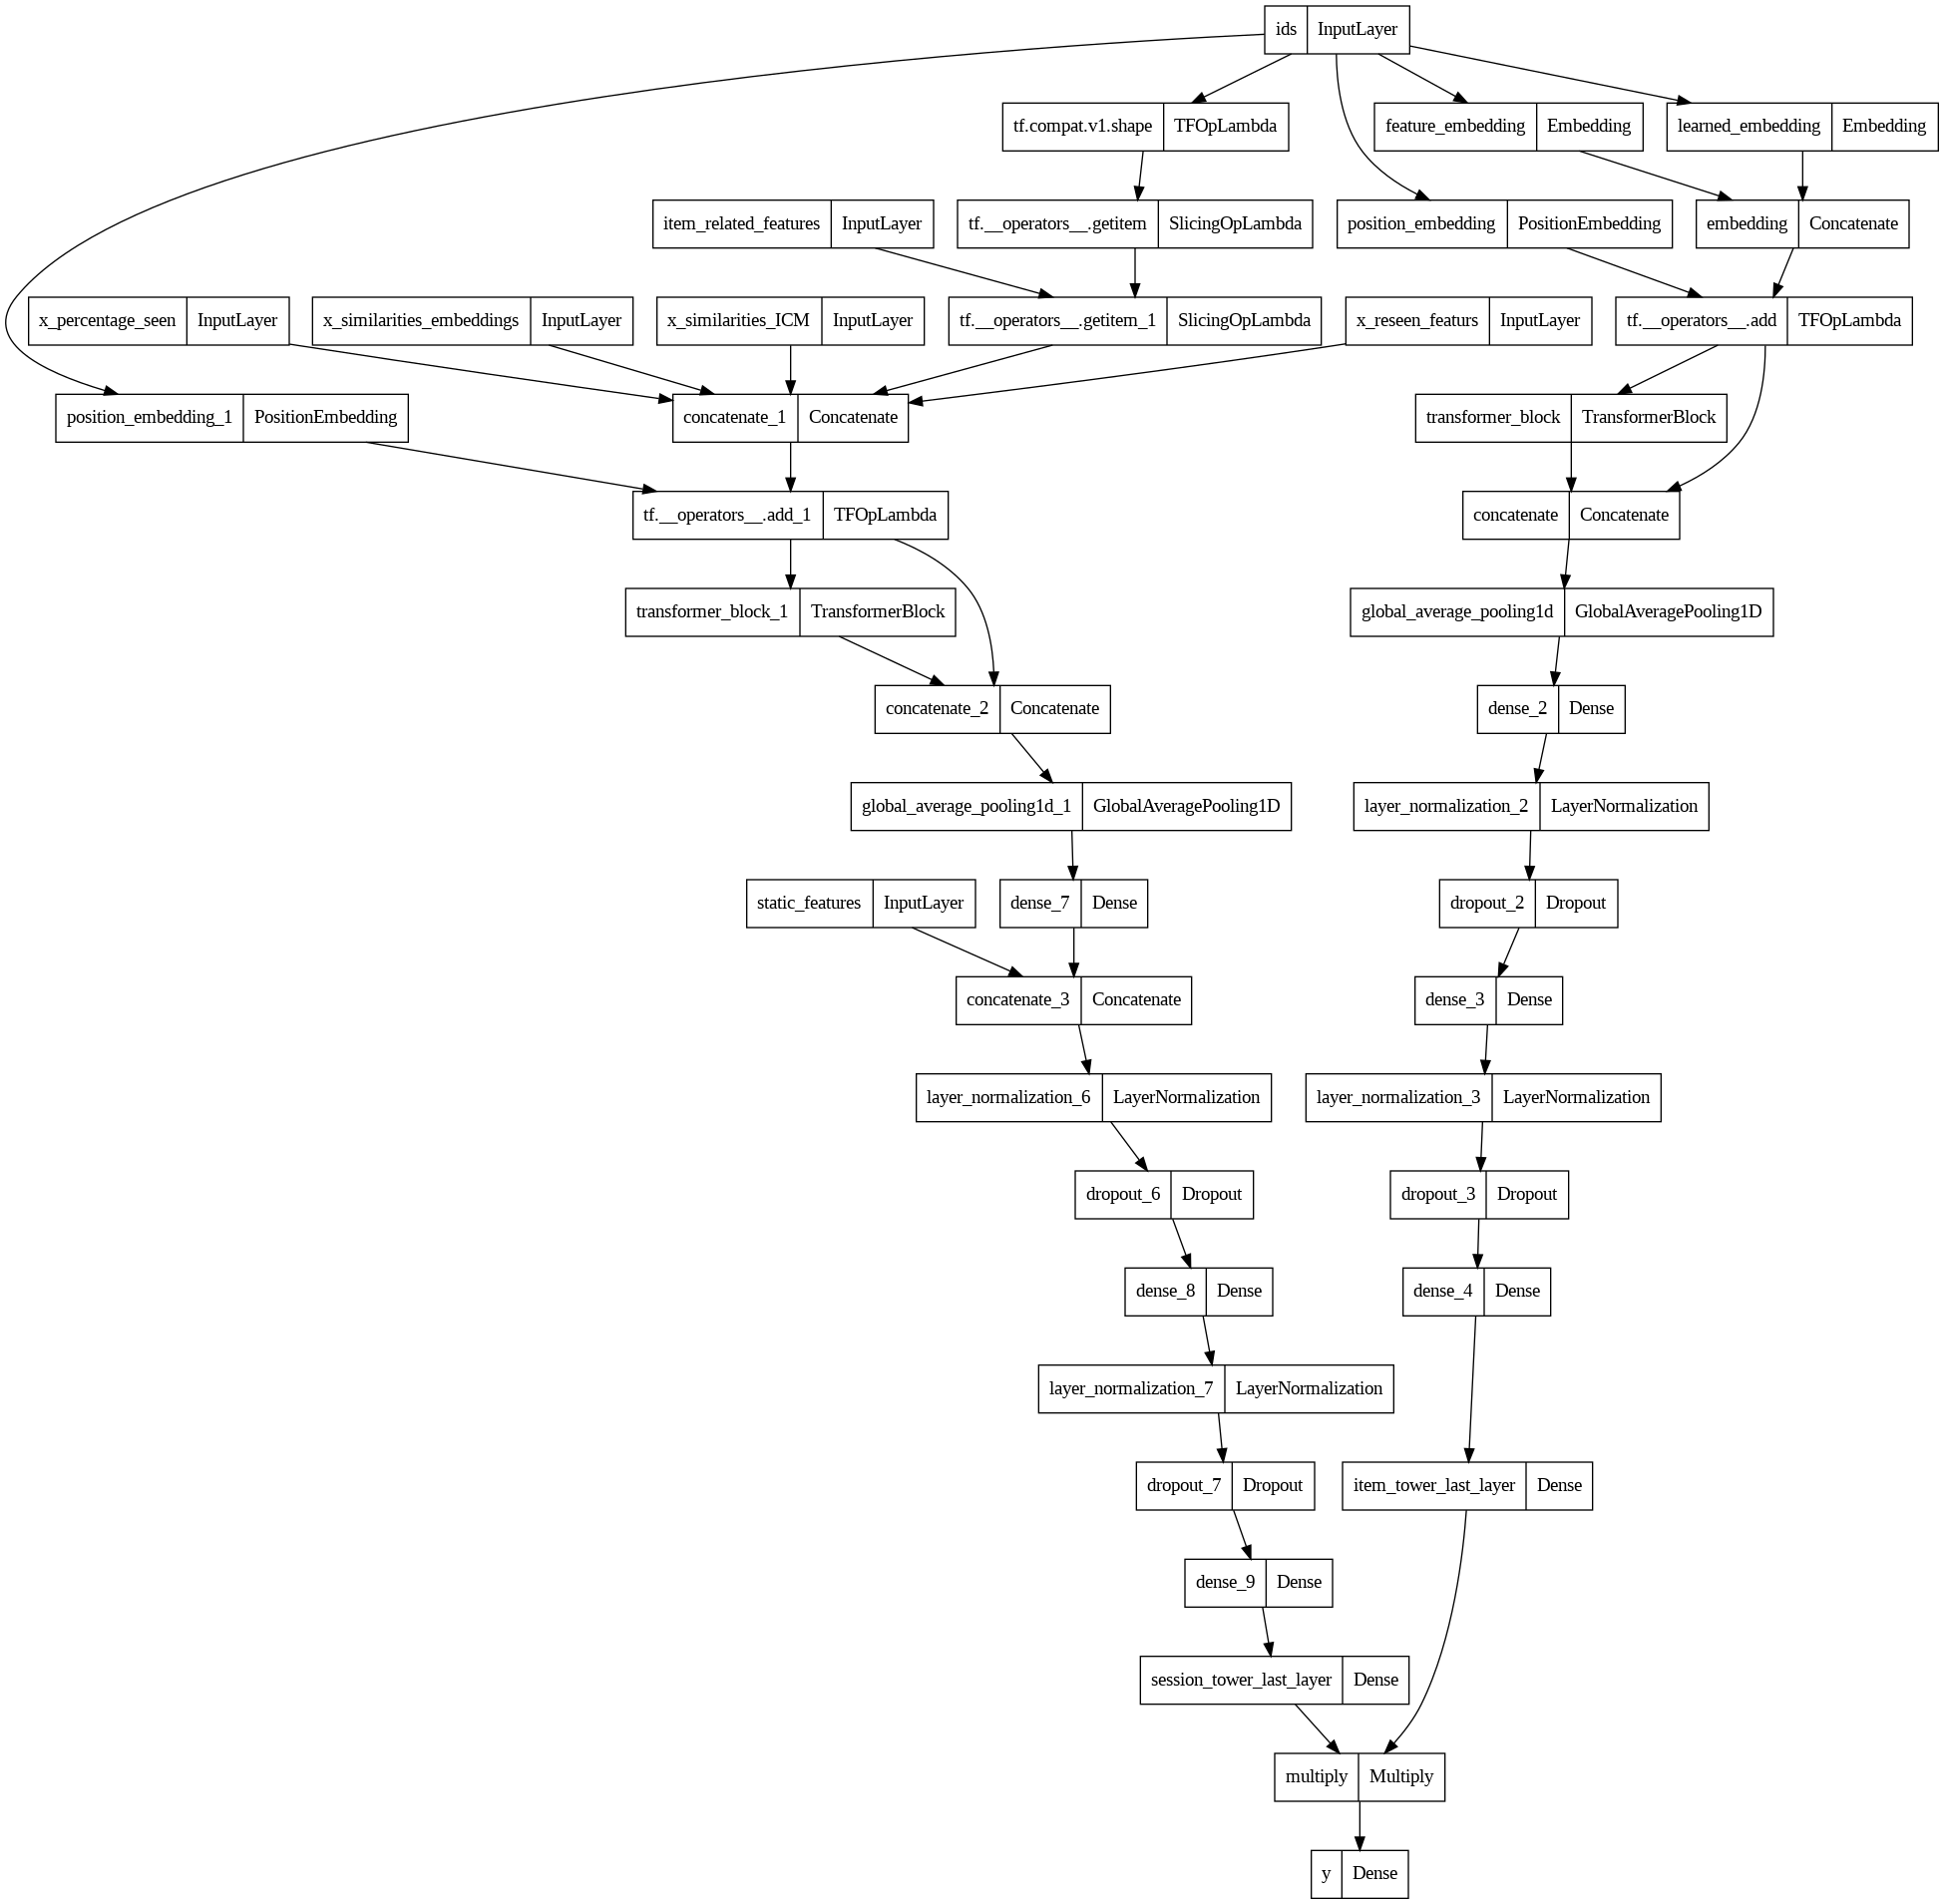

In [131]:
tf.keras.utils.plot_model(model_for_training,to_file="./model_2towers.png", expand_nested=True)

In [ ]:
# @title Prepare test predictions Leaderboard

In [45]:
temp=pd.read_csv("./dataset/processed_data/macro_feats_NN_leaderboard.csv")
temp["item_id"]=temp["item_id"].map(ast.literal_eval)
temp["timedelta"]=temp["timedelta"].map(ast.literal_eval)

test_leaderboard_sessions=temp
gc.collect()

1254

In [46]:
x_reseen_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].apply(is_reseen),
    padding='post',
    maxlen=100,
)

x_percentage_seen_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].apply(percentage_seen),
    padding='post',
    maxlen=100,
)

In [47]:
x_simils_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].progress_apply(similarity_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float32',
)
x_simils_feats_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].progress_apply(similarity_feats_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float32',
)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [48]:
for col in ['length_of_session_seconds','avg_time_spent_per_item_seconds','variance_time_spent_per_item_seconds']:
    test_leaderboard_sessions[col]=np.log10(test_leaderboard_sessions[col]+1)
for col in ['n_seen_items','n_unique_items']:
    test_leaderboard_sessions[col]=test_leaderboard_sessions[col]/100

In [49]:
x_test_leaderboard = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'],
    padding='post',
    maxlen=100
)

x_test_leaderboard[0]

array([3404,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [50]:
for item_related_feature in item_related_features:
  print('Padding {}'.format(item_related_feature))
  x_test_item_related = tf.keras.preprocessing.sequence.pad_sequences(
      test_leaderboard_sessions[item_related_feature],
      dtype='float16',
      maxlen=100,
      padding='post'
    )

Padding timedelta


In [51]:
if len(item_related_features) == 1:
    x_test_item_related = np.expand_dims(x_test_item_related, axis=-1)

In [54]:
print(static_features)

[[ 0.00000000e+00  1.00000000e+00  2.07911691e-01 ...  1.85009321e-01
   2.35478124e-01  2.35478124e-01]
 [ 0.00000000e+00  1.00000000e+00  2.07911691e-01 ...  1.77360546e-01
   2.33751514e-01  2.33751514e-01]
 [ 0.00000000e+00  1.00000000e+00  2.07911691e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [-1.04528463e-01  9.94521895e-01 -1.13310778e-15 ...  3.34870505e-01
   3.89594760e-01  3.89594760e-01]
 [-9.15016187e-02  9.95804928e-01 -1.13310778e-15 ...  3.46932220e-01
   4.19778330e-01  4.19778330e-01]
 [-8.28082075e-02  9.96565502e-01 -1.13310778e-15 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]]


In [55]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (
        test_leaderboard_sessions['session_id'],
     (
        x_test_leaderboard,
        x_reseen_test/100,
        x_percentage_seen_test,
        x_simils_test,
        x_simils_feats_test,
        x_test_item_related,
        test_leaderboard_sessions[static_features_names].to_numpy()
     )
    )
).batch(2048)

submission_set.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)))

In [ ]:
# @title Prepare test predictions Final

In [56]:
temp=pd.read_csv("./dataset/processed_data/macro_feats_NN_final.csv")
temp["item_id"]=temp["item_id"].map(ast.literal_eval)
temp["timedelta"]=temp["timedelta"].map(ast.literal_eval)

test_leaderboard_sessions=temp
gc.collect()

946

In [57]:
x_reseen_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].apply(is_reseen),
    padding='post',
    maxlen=100,
)

x_percentage_seen_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].apply(percentage_seen),
    padding='post',
    maxlen=100,
)

In [58]:
x_simils_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].progress_apply(similarity_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float32',
)
x_simils_feats_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'].progress_apply(similarity_feats_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float32',
)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [59]:
for col in ['length_of_session_seconds','avg_time_spent_per_item_seconds','variance_time_spent_per_item_seconds']:
    test_leaderboard_sessions[col]=np.log10(test_leaderboard_sessions[col]+1)
for col in ['n_seen_items','n_unique_items']:
    test_leaderboard_sessions[col]=test_leaderboard_sessions[col]/100

In [60]:
x_test_leaderboard = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'],
    padding='post',
    maxlen=100
)

x_test_leaderboard[0]

array([4785,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [61]:
for item_related_feature in item_related_features:
    print('Padding {}'.format(item_related_feature))
    x_test_item_related = tf.keras.preprocessing.sequence.pad_sequences(
        test_leaderboard_sessions[item_related_feature],
        dtype='float16',
        maxlen=100,
        padding='post'
    )

Padding timedelta


In [62]:
if len(item_related_features) == 1:
    x_test_item_related = np.expand_dims(x_test_item_related, axis=-1)

# Evaluation

### 1. Prepare candidates last month

In [63]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (
        x_session_ids_last_month,
     (
        x_ids_last_month,
        x_reseen_last_month/100,
        x_percentage_seen_last_month,
        x_simils_last_month,
        x_simils_feats_last_month,
        x_item_related_last_month,
        static_features_last_month
     )
    )
).batch(512)
submission_set.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)))

In [64]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (
        test_leaderboard_sessions['session_id'],
     (
        x_test_leaderboard,
        x_reseen_test/100,
        x_percentage_seen_test,
        x_simils_test,
        x_simils_feats_test,
        x_test_item_related,
        test_leaderboard_sessions[static_features_names].to_numpy()
     )
    )
).batch(2048)
submission_set.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)))

In [123]:
submission_df = pd.DataFrame(
    {
        'session_id':[],
        'item_id':[],
        'score':[],
        'rank':[]
    }
)

submission_df.head()

,session_id,item_id,score,rank


In [124]:
candidates=np.array([i+1 for i in range(4990)]) # this is for the test month
candidates

array([   1,    2,    3, ..., 4988, 4989, 4990])

In [132]:
for session_ids, sessions in submission_set:
    predicted_scores=model_for_training(sessions).numpy()
    mask = np.ones(predicted_scores.shape[1], dtype=bool)
    mask[candidates] = False
    predicted_scores[...,mask]=-np.inf
    predicted_scores=tf.convert_to_tensor(predicted_scores)
    preds=tf.math.top_k(predicted_scores, k=100)
    scores=preds.values.numpy()
    code = preds.indices.numpy()
    prediction = pd.DataFrame(
        {
            'session_id':session_ids,
            'item_id':[tuple(v) for v in code],
            'score':[tuple(v) for v in scores],
            'rank':[tuple([rank for rank in range(1, 101)]) for id in session_ids]
        }
        )

    submission_df = pd.concat([submission_df, prediction])

submission_df.head()

ResourceExhaustedError: Exception encountered when calling layer 'softmax' (type Softmax).

{{function_node __wrapped__Softmax_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[2048,5,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Softmax] name: 

Call arguments received by layer 'softmax' (type Softmax):
  • inputs=tf.Tensor(shape=(2048, 5, 100, 100), dtype=float32)
  • mask=None

In [72]:
if not os.path.exists('./dataset/candidates/two_towers/train'):
  os.makedirs('./dataset/candidates/two_towers/train')

submission_df.to_csv(
     #'./dataset/candidates/NN/Transformer/train/candidates.csv',
     './dataset/candidates/two_towers/train/candidates.csv',
     index=False
     )

### 2. Evaluation

In [114]:
test_sessions= pd.read_csv("./dataset/original_data/test_final_purchases.csv")

In [115]:
test_sessions.head()

,session_id,item_id,date
0,61,20236,2021-06-01 08:12:53.513
1,96,19912,2021-06-19 18:00:35.142
2,185,13115,2021-06-07 15:55:53.129
3,224,23733,2021-06-14 16:04:34.465
4,285,20057,2021-06-29 15:35:04.948


In [116]:
submissions_df_final = {}
submissions_df_final = submission_df.drop('score', axis=1).explode(['item_id', 'rank']).astype(int)

In [117]:
submissions_df_final.head()

,session_id,item_id,rank
0,61,1998,1
0,61,4260,2
0,61,1468,3
0,61,2950,4
0,61,3754,5


In [118]:
final_comprasion_df = pd.merge(test_sessions, submissions_df_final, on=["session_id", "item_id"], how="left").fillna(100)

In [119]:
mrr_dict = (1 / final_comprasion_df.groupby('session_id')['rank'].min()).mean()

In [120]:
print(mrr_dict)

0.010082784436062567


In [ ]:
# NHITS=len(dataset['Session_Id'].unique())
# HITRATE=NHITS/81600 #approximate value
# HITRATE

In [ ]:
# submission_df_tr=pd.read_csv("../dataset/candidates/NN/Transformer/train/candidates.csv")
# if just_checking_integrity:
#     submission_df_tr["score"]=submission_df_tr["score"].apply(lambda x:x.replace("-inf","0"))
#     submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
# else:
#     submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
# submission_df_tr["code"]=submission_df_tr["code"].map(ast.literal_eval)
# submission_df_tr["rank"]=submission_df_tr["rank"].map(ast.literal_eval)
# submission_df_tr = submission_df_tr.explode(['code','score', 'rank'])
# submission_df_tr[["session_id","code","rank"]]=submission_df_tr[["session_id","code","rank"]].astype(int)
# submission_df_tr.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_transformer","score":"score_transformer"},inplace=True)

# dataset = submission_df_tr

In [ ]:
# if just_checking_integrity:
#     dataset=dataset[:int(0.5*len(dataset))]

In [ ]:
# import numpy as np
# sessions=np.unique(dataset["Session_Id"])
# train=pd.DataFrame()
# train["Session_Id"]=sessions
# if just_checking_integrity:
#     train["Item_ID"]=bought[:len(sessions)]
# else:
#     train["Item_ID"]=bought
# train["target"]=1

# dataset=dataset.merge(train,on=["Session_Id","Item_ID"],how="left")
# dataset.fillna(0,inplace=True)
# dataset["target"]=dataset["target"].astype("int8")

# gc.collect()

In [ ]:
# train_sessions=train["Session_Id"].tolist()
# train_set=dataset[dataset["Session_Id"].isin(train_sessions)]
# train_set=train_set.sort_values("Session_Id")

# qids_train = train_set[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
# X_train=train_set.drop(["target","Session_Id","Item_ID"],axis=1)
# y_train=train_set["target"]

In [ ]:
# print(dataset.head())
# print(y_train.head())

In [ ]:
# mrr = mrr_top(y_true=y_train, y_pred=)